In [1]:
# Importing Qiskit and IonQ accounts
from qiskit import IBMQ
from qiskit_ionq import IonQProvider

# Loading your IBM Quantum and IonQ accounts
# IBMQ.save_account('token', overwrite=True)
IBMQ.load_account()
ibmq_provider = IBMQ.get_provider('ibm-q-skku','yonsei-uni','yu-students')
# ionq_provider = IonQProvider("")

In [2]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info.operators import Operator
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from quantum_walk_simulation import staggered_dsg_circuit_log3t

In [3]:
size_degree = 2
shots = 4000

displacement_dict = {"0000":0, "0001":1, "0010":1, 
                     "0011":9, "0100":7, "0101":4,
                     "0110":9, "0111":4, "1000":7}

In [5]:
sys = 'ibmq_qasm_simulator'
sim = ibmq_provider.get_backend(sys)

In [6]:
steps = 300
dt = 0.01
layers = 10
t = np.linspace(dt, steps*dt, steps)
name = f'dsg_log3tqw_{steps*dt:.1f}s_{layers:d}ly'

In [7]:
circs = []

# Build a circuit list.
for i in range(steps):
    circs.append(staggered_dsg_circuit_log3t(size_degree, t[i], layers))

# circs[20].draw('mpl')

# Need to transpile the circuits first.
transpiled_circs = transpile(circs, backend=sim, optimization_level=2)

# Use Job Manager to break the circuits into multiple jobs.
job_manager = IBMQJobManager()
job_set = job_manager.run(transpiled_circs, backend=sim, name=sys+'_'+name, shots=shots)

In [8]:
results = job_set.results()
counts_list = list()
for i in range(steps):
    counts_list.append(results.get_counts(i))

In [9]:
msd_list = list()

for i in range(steps):
    valid_count = 0
    for bit, count in counts_list[i].items():
        valid_count += (displacement_dict.get(bit, -1) > -1)*count
    msd_temp = 0.
    for bit, count in counts_list[i].items():
        msd_temp += displacement_dict.get(bit, 0)*count/valid_count
    msd_list.append(msd_temp)

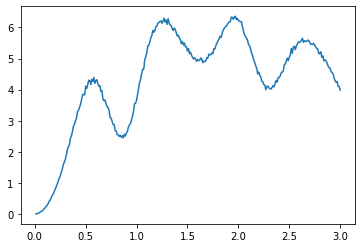

In [10]:
plt.plot(t, msd_list)

In [11]:
import pickle

with open(f'simulator/{sys}_{name}_counts_list.pkl','wb') as file :
    pickle.dump(counts_list, file)

In [12]:
import csv

with open(f'simulator/{sys}_{name}_msd_list.csv','w') as file :
    write = csv.writer(file)
    write.writerow(msd_list)